# Data Science 2 - ESEO DSMT 
## XGBoost and LightGBM
### 15 Nov 2021  -- Prof. R. LONGO

1. Basics
2. Advanced
3. Tuning

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import confusion_matrix,classification_report

import warnings
warnings.filterwarnings('ignore')

##  1. Basics

In [2]:
from numpy import loadtxt
from sklearn.model_selection import train_test_split

In [3]:
# load data pima-indians-diabetes
dataset = loadtxt('data.txt', delimiter=",")
print(type(dataset))


<class 'numpy.ndarray'>


In [4]:
print(dataset.shape)

(768, 9)


In [16]:
#formation X,y 
y = dataset[:,-1]
X = dataset[:,:-1]
y = y.reshape((dataset.shape[0],1))
print(X.shape,y.shape)


(768, 8) (768, 1)


In [30]:
val, occu=np.unique(y,return_counts=True) #voir ce qu'il y a dans y et compter chaque valeur

In [39]:
print(occu[0]/(occu[0]+occu[1]))
print("/!\ unbalanced classes")

0.6510416666666666
/!\ unbalanced classes


In [41]:
#Train/Test split
seed = 10
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=seed)

In [50]:
print(np.unique(y_train,return_counts=True)[1][0]/len(y_train))
print(np.unique(y_test,return_counts=True)[1][0]/len(y_test))
#Pourcentage proche mais différent alors qu'il faut garder ce pourcentage. 

0.6596091205211726
0.6168831168831169


In [53]:
#On utilise le param stratify pour garder l'équilibre dans les données
X_train, X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=seed,stratify=y)
print(np.unique(y_train,return_counts=True)[1][0]/len(y_train))
print(np.unique(y_test,return_counts=True)[1][0]/len(y_test))

0.6514657980456026
0.6493506493506493


### XGBoost

In [84]:
import xgboost as xgb
model = xgb.XGBClassifier(random_state=seed);
model.fit(X_train,y_train)
model.score(X_test,y_test)# technique pas terrible car les classes ne sont pas balancées

[15:16:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7402597402597403

In [63]:
y_predict = model.predict(X_test)

In [64]:
confusion_matrix(y_test,y_predict)

array([[77, 23],
       [17, 37]], dtype=int64)

In [75]:
# On veut augmenter les valeurs sur la diagonales et réduire à l'extérieur
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.77      0.79       100
         1.0       0.62      0.69      0.65        54

    accuracy                           0.74       154
   macro avg       0.72      0.73      0.72       154
weighted avg       0.75      0.74      0.74       154



#### For Classification Report 
Accuracy: The accuracy returns the proportion of correct predictions.
\
Accuracy = (TP + TN)/(TP + TN + FP + FN) 
\
\
Precision: The precision returns the proportion of true positives among all the values predicted as positive.
\
Precision = TP/(TP + FP) 
\
Negative Predictive Value = = TN/(TN + FN) 
\
\
Recall (sensitivity): The recall returns the proportion of positive values correctly predicted.
\
Recall = TP/(TP + FN)
\
Specificity: The specificity returns the proportion of negative values correctly predicted.
\
Specificity: TN/ (TN + FP) 
\
\
F1-score: The f1-score is the harmonic mean of precision and recall. It is often used to compare classifiers.
\
F1-score = (2 x Precision x Recall)/(Precision + Recall) 

In [82]:
from sklearn.model_selection import KFold, cross_val_score,StratifiedKFold
cv = 10
kfold = StratifiedKFold(n_splits=cv,random_state=seed)
results=cross_val_score(model,X_train,y_train,cv = kfold,n_jobs=-1)#n_jobs donne tous les cores de notre processeur
print("Accuracy:",results.mean())
print("std:",results.std())

Accuracy: 0.7247752511898466
std: 0.06449168269666085


## 2. Advanced


#### 2.1 Feature Selection Using Feature Importance

[15:33:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0.06784084 0.17221135 0.10045662 0.07436399 0.06784084 0.17482062
 0.19960861 0.14285715]


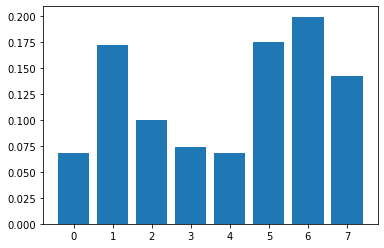

In [104]:
#feature_importances_
model = xgb.XGBClassifier(importance_type='weight',random_seed=seed)
model.fit(X_train,y_train,eval_metric='logloss')
model.score(X_test,y_test)
print(model.feature_importances_)
plt.bar(range(len(model.feature_importances_)),model.feature_importances_);

In [105]:
#Using the Built-in XGBoost Feature Importance PLOT
from xgboost import plot_importance
plot_importance(model,importance_type='weight')

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

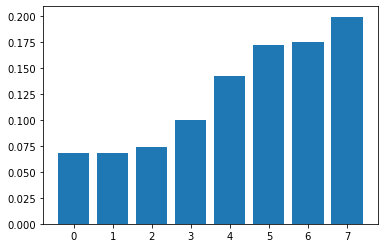

In [107]:
thresholds = np.sort(model.feature_importances_)
plt.bar(range(len(thresholds)),thresholds);

In [119]:
from sklearn.feature_selection import SelectFromModel
for threshold in thresholds:
    selection = SelectFromModel(model,threshold=threshold,prefit=True) #feature selection
    #Transform X_train
    select_X_train = selection.transform(X_train)
    
    #train X_train
    selection_model = xgb.XGBClassifier(random_state=seed)
    selection_model.fit(select_X_train,y_train,eval_metric='logloss')
    
    #Evaluation Test
    select_X_test = selection.transform(X_test)
    accuracy = selection_model.score(select_X_test,y_test)
    print("Thresholds:",threshold)
    print("nFeature:",select_X_train.shape[1])
    print("accuracy:",accuracy, "\n")
    

Thresholds: 0.06784084
nFeature: 8
accuracy: 0.7402597402597403 

Thresholds: 0.06784084
nFeature: 8
accuracy: 0.7402597402597403 

Thresholds: 0.07436399
nFeature: 6
accuracy: 0.7337662337662337 

Thresholds: 0.10045662
nFeature: 5
accuracy: 0.7012987012987013 

Thresholds: 0.14285715
nFeature: 4
accuracy: 0.7402597402597403 

Thresholds: 0.17221135
nFeature: 3
accuracy: 0.7337662337662337 

Thresholds: 0.17482062
nFeature: 2
accuracy: 0.5909090909090909 

Thresholds: 0.19960861
nFeature: 1
accuracy: 0.5194805194805194 



#### 2.2 Monitor Training Performance and Early Stopping
XGBoost supports a suite of evaluation metrics (not limited to):
\
 rmse for root mean squared error. (Regression and not Classification)
\
 mae for mean absolute error. (Regression and not Classification)
\
 logloss for binary logarithmic loss and mlogloss for multiclass log loss (cross entropy).
\
 error for classification error.
\
 auc for area under ROC curve (for UNBALANCED CLASSES)
\
 aucpr calculates the area under the Precision Recall curve (for UNBALANCED CLASSES)

In [129]:
# Monitor Training Performance

model = xgb.XGBClassifier(n_estimators=50,random_state=seed)
eval_set = [(X_test,y_test)]
model.fit(X_train,y_train,eval_metric="auc",eval_set=eval_set,verbose=True)

print(model.score(X_test,y_test))

[0]	validation_0-auc:0.81759
[1]	validation_0-auc:0.80278
[2]	validation_0-auc:0.80796
[3]	validation_0-auc:0.80732
[4]	validation_0-auc:0.80963
[5]	validation_0-auc:0.80972
[6]	validation_0-auc:0.81787
[7]	validation_0-auc:0.82380
[8]	validation_0-auc:0.82954
[9]	validation_0-auc:0.83139
[10]	validation_0-auc:0.83000
[11]	validation_0-auc:0.83056
[12]	validation_0-auc:0.82065
[13]	validation_0-auc:0.82120
[14]	validation_0-auc:0.81778
[15]	validation_0-auc:0.81667
[16]	validation_0-auc:0.81593
[17]	validation_0-auc:0.81463
[18]	validation_0-auc:0.81778
[19]	validation_0-auc:0.82204
[20]	validation_0-auc:0.81870
[21]	validation_0-auc:0.81889
[22]	validation_0-auc:0.81778
[23]	validation_0-auc:0.81852
[24]	validation_0-auc:0.81519
[25]	validation_0-auc:0.81611
[26]	validation_0-auc:0.81667
[27]	validation_0-auc:0.81148
[28]	validation_0-auc:0.81074
[29]	validation_0-auc:0.81037
[30]	validation_0-auc:0.80481
[31]	validation_0-auc:0.80111
[32]	validation_0-auc:0.79741
[33]	validation_0-au

In [153]:
# Early Stopping

model = xgb.XGBClassifier(n_estimators=50,random_state=seed)
eval_set = [(X_test,y_test)]
model.fit(X_train,y_train,eval_metric="auc",early_stopping_rounds=20,eval_set=eval_set,verbose=True)
#Trouve le meilleur et si les 20 suivants ne sont pas meilleurs alors il s'arrête (early stopping)

print(model.score(X_test,y_test))


[0]	validation_0-auc:0.81759
[1]	validation_0-auc:0.80278
[2]	validation_0-auc:0.80796
[3]	validation_0-auc:0.80732
[4]	validation_0-auc:0.80963
[5]	validation_0-auc:0.80972
[6]	validation_0-auc:0.81787
[7]	validation_0-auc:0.82380
[8]	validation_0-auc:0.82954
[9]	validation_0-auc:0.83139
[10]	validation_0-auc:0.83000
[11]	validation_0-auc:0.83056
[12]	validation_0-auc:0.82065
[13]	validation_0-auc:0.82120
[14]	validation_0-auc:0.81778
[15]	validation_0-auc:0.81667
[16]	validation_0-auc:0.81593
[17]	validation_0-auc:0.81463
[18]	validation_0-auc:0.81778
[19]	validation_0-auc:0.82204
[20]	validation_0-auc:0.81870
[21]	validation_0-auc:0.81889
[22]	validation_0-auc:0.81778
[23]	validation_0-auc:0.81852
[24]	validation_0-auc:0.81519
[25]	validation_0-auc:0.81611
[26]	validation_0-auc:0.81667
[27]	validation_0-auc:0.81148
[28]	validation_0-auc:0.81074
[29]	validation_0-auc:0.81037
0.7792207792207793


In [219]:
print(model.best_score)
print(model.best_iteration)
print(model.best_ntree_limit)

AttributeError: 'LGBMClassifier' object has no attribute 'best_score'


## 3.  Tuning


### Table of common parameters used for XGBoost and some suggestions for tuning:
- Number of Trees (n estimators): set to a fixed value between 100 and 1000, depending on the dataset size.

- Learning Rate (or eta); simplified to the ratio: [2 to 10]/ Ntrees , depending on the
number of trees.
- Row Sampling (subsample): grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (colsample bytree and maybe colsample by level): grid searched
values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (min child weight): simplified to the ratio: 3/rare events , where rare events is the percentage of rare event observations in the dataset.
- Tree Size (max depth): grid searched values in the range [4, 6, 8, 10].
- Min Split Gain (gamma): fixed with a value of zero (Pruning).
- scale_pos_weight (for unbalanced classes):grid searched values in the range [1, 3, 5]# Note that  XGBoost recommends sum(neg instances)/sum(pos istances)
 
https://www.youtube.com/watch?v=LgLcfZjNF44 

In [155]:
model = xgb.XGBClassifier(n_estimators=50,random_state=seed)

In [157]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV,StratifiedKFold

In [170]:
param_grid = {
    'max_depth':[4,6,8,10],
    'scale_pos_weight':[1,3,5],
    'subsample':[0.5,0.75,1],
    'colsample_bytree':[0.4,0.6,0.8,1],
    'learning_rate':[0.01,0.05,0.1],
    'min_child_weight':[1,3,5]
}

In [180]:
y_hat_grid = GridSearchCV(model, param_grid,scoring='roc_auc',cv=10)
y_hat_grid.fit(X_train,y_train,eval_metric='logloss')

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=10, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_me

In [175]:
print(y_hat_grid.best_score_)
print(y_hat_grid.best_params_)

0.8359199134199133
{'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 4, 'scale_pos_weight': 3, 'subsample': 1}


In [178]:
y_hat_grid_2 = RandomizedSearchCV(model, param_grid,scoring='roc_auc',cv=10,n_iter=20,random_state=seed)
y_hat_grid_2.fit(X_train,y_train,eval_metric='logloss')

RandomizedSearchCV(cv=10,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraint...
                                           predictor=None, random_state=10,
                                           reg_alpha=None, reg_lambda=None,
                             

In [179]:
print(y_hat_grid_2.best_score_)
print(y_hat_grid_2.best_params_)

0.8327380952380953
{'subsample': 1, 'scale_pos_weight': 5, 'max_depth': 4, 'learning_rate': 0.05, 'colsample_bytree': 0.6}


In [186]:
final_model = xgb.XGBClassifier(n_estimators=50, 
                                learning_rate=0.05, 
                                colsample_bytree=0.6,
                                max_depth=4,
                                scale_pos_weight=5,
                                subsample=1)

In [191]:
final_model.fit(X_train,y_train,eval_metric="auc",early_stopping_rounds=20,eval_set=eval_set,verbose=True)


[0]	validation_0-auc:0.78028
[1]	validation_0-auc:0.79380
[2]	validation_0-auc:0.80565
[3]	validation_0-auc:0.82667
[4]	validation_0-auc:0.83037
[5]	validation_0-auc:0.83370
[6]	validation_0-auc:0.82778
[7]	validation_0-auc:0.82333
[8]	validation_0-auc:0.81435
[9]	validation_0-auc:0.81991
[10]	validation_0-auc:0.81843
[11]	validation_0-auc:0.80944
[12]	validation_0-auc:0.80574
[13]	validation_0-auc:0.80056
[14]	validation_0-auc:0.80111
[15]	validation_0-auc:0.80593
[16]	validation_0-auc:0.80537
[17]	validation_0-auc:0.80574
[18]	validation_0-auc:0.80407
[19]	validation_0-auc:0.80148
[20]	validation_0-auc:0.80167
[21]	validation_0-auc:0.80315
[22]	validation_0-auc:0.80519
[23]	validation_0-auc:0.80907
[24]	validation_0-auc:0.81037


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6,
              enable_categorical=False, gamma=0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=4, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=5,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [192]:
print("model best score:",final_model.best_score)
print("model best iteration:", final_model.best_iteration)
print("model ntree limit:",final_model.best_ntree_limit)

model best score: 0.833704
model best iteration: 5
model ntree limit: 6


In [203]:
final_model = xgb.XGBClassifier(n_estimators=6, 
                                learning_rate=0.05, 
                                colsample_bytree=0.6,
                                max_depth=4,
                                scale_pos_weight=1,
                                subsample=1,
                                random_state=seed)

In [204]:
final_model.fit(X_train,y_train,eval_metric="auc");


In [205]:
y_predict = final_model.predict(X_test)
confusion_matrix(y_test,y_predict)

array([[87, 13],
       [19, 35]], dtype=int64)

In [206]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.82      0.87      0.84       100
         1.0       0.73      0.65      0.69        54

    accuracy                           0.79       154
   macro avg       0.77      0.76      0.77       154
weighted avg       0.79      0.79      0.79       154



### LightGBM

In [207]:
import lightgbm as lgb

In [209]:
model = lgb.LGBMClassifier(random_state=seed)
model.fit(X_train,y_train)
y_predict = model.predict(X_test)

In [210]:
confusion_matrix(y_test,y_predict)

array([[78, 22],
       [18, 36]], dtype=int64)

In [211]:
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       100
         1.0       0.62      0.67      0.64        54

    accuracy                           0.74       154
   macro avg       0.72      0.72      0.72       154
weighted avg       0.75      0.74      0.74       154



In [227]:
lgb.plot_importance(model,importance_type='split');

In [230]:
thresholds = np.sort(model.feature_importances_)
for threshold in thresholds:
    selection = SelectFromModel(model,threshold=threshold,prefit=True) #feature selection
    #Transform X_train
    select_X_train = selection.transform(X_train)
    
    #train X_train
    selection_model = xgb.XGBClassifier(random_state=seed)
    selection_model.fit(select_X_train,y_train,eval_metric='auc')
    
    #Evaluation Test
    select_X_test = selection.transform(X_test)
    accuracy = selection_model.score(select_X_test,y_test)
    print("Thresholds:",threshold)
    print("nFeature:",select_X_train.shape[1])
    print("accuracy:",accuracy, "\n")
    

Thresholds: 13
nFeature: 8
accuracy: 0.7402597402597403 

Thresholds: 15
nFeature: 7
accuracy: 0.7077922077922078 

Thresholds: 17
nFeature: 6
accuracy: 0.7402597402597403 

Thresholds: 18
nFeature: 5
accuracy: 0.7532467532467533 

Thresholds: 41
nFeature: 4
accuracy: 0.7402597402597403 

Thresholds: 44
nFeature: 3
accuracy: 0.7012987012987013 

Thresholds: 59
nFeature: 2
accuracy: 0.7272727272727273 

Thresholds: 63
nFeature: 1
accuracy: 0.7402597402597403 



In [217]:
# Advanced - early stopping
model = lgb.LGBMClassifier(n_estimators=50,random_state=seed)
eval_set = [(X_test,y_test)]
model.fit(X_train,y_train,eval_metric="auc",eval_set=eval_set,verbose=True);


[1]	valid_0's auc: 0.814074	valid_0's binary_logloss: 0.610885
[2]	valid_0's auc: 0.798333	valid_0's binary_logloss: 0.590222
[3]	valid_0's auc: 0.796759	valid_0's binary_logloss: 0.571087
[4]	valid_0's auc: 0.798056	valid_0's binary_logloss: 0.558027
[5]	valid_0's auc: 0.799259	valid_0's binary_logloss: 0.545982
[6]	valid_0's auc: 0.802315	valid_0's binary_logloss: 0.534139
[7]	valid_0's auc: 0.821111	valid_0's binary_logloss: 0.521183
[8]	valid_0's auc: 0.816296	valid_0's binary_logloss: 0.514922
[9]	valid_0's auc: 0.822778	valid_0's binary_logloss: 0.506717
[10]	valid_0's auc: 0.828704	valid_0's binary_logloss: 0.499747
[11]	valid_0's auc: 0.83	valid_0's binary_logloss: 0.494773
[12]	valid_0's auc: 0.833889	valid_0's binary_logloss: 0.488841
[13]	valid_0's auc: 0.829352	valid_0's binary_logloss: 0.489166
[14]	valid_0's auc: 0.826574	valid_0's binary_logloss: 0.4885
[15]	valid_0's auc: 0.827315	valid_0's binary_logloss: 0.486023
[16]	valid_0's auc: 0.828056	valid_0's binary_logloss: 

In [218]:

#early stopping
model.fit(X_train,y_train,eval_metric="auc",eval_set=eval_set,verbose=True,early_stopping_rounds=10)


[1]	valid_0's auc: 0.814074	valid_0's binary_logloss: 0.610885
[2]	valid_0's auc: 0.798333	valid_0's binary_logloss: 0.590222
[3]	valid_0's auc: 0.796759	valid_0's binary_logloss: 0.571087
[4]	valid_0's auc: 0.798056	valid_0's binary_logloss: 0.558027
[5]	valid_0's auc: 0.799259	valid_0's binary_logloss: 0.545982
[6]	valid_0's auc: 0.802315	valid_0's binary_logloss: 0.534139
[7]	valid_0's auc: 0.821111	valid_0's binary_logloss: 0.521183
[8]	valid_0's auc: 0.816296	valid_0's binary_logloss: 0.514922
[9]	valid_0's auc: 0.822778	valid_0's binary_logloss: 0.506717
[10]	valid_0's auc: 0.828704	valid_0's binary_logloss: 0.499747
[11]	valid_0's auc: 0.83	valid_0's binary_logloss: 0.494773
[12]	valid_0's auc: 0.833889	valid_0's binary_logloss: 0.488841
[13]	valid_0's auc: 0.829352	valid_0's binary_logloss: 0.489166
[14]	valid_0's auc: 0.826574	valid_0's binary_logloss: 0.4885
[15]	valid_0's auc: 0.827315	valid_0's binary_logloss: 0.486023
[16]	valid_0's auc: 0.828056	valid_0's binary_logloss: 

LGBMClassifier(n_estimators=50, random_state=10)

In [224]:
print(model.best_iteration_)
print(model.best_score_)


12
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.8338888888888889), ('binary_logloss', 0.4888412646882451)])})


In [272]:
param_grid = {
    "boosting_type":['gbdt','rf'],
    'max_depth':[4,6,8,10],
    'scale_pos_weight':[1,3,5],
    'subsample':[0.5,0.75,1],
    'colsample_bytree':[0.4,0.6,0.8,1],
    'learning_rate':[0.01,0.05,0.1],
    'min_child_weight':[1,3,5],
    "subsample_for_bin":[2000000]
}

In [273]:
y_hat_grid_2 = RandomizedSearchCV(model, param_grid,scoring='roc_auc',cv=10,n_iter=20,random_state=seed)
y_hat_grid_2.fit(X_train,y_train,eval_metric='auc')

RandomizedSearchCV(cv=10,
                   estimator=LGBMClassifier(n_estimators=50, random_state=10),
                   n_iter=20,
                   param_distributions={'boosting_type': ['gbdt', 'rf'],
                                        'colsample_bytree': [0.4, 0.6, 0.8, 1],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8, 10],
                                        'min_child_weight': [1, 3, 5],
                                        'scale_pos_weight': [1, 3, 5],
                                        'subsample': [0.5, 0.75, 1],
                                        'subsample_for_bin': [2000000]},
                   random_state=10, scoring='roc_auc')

In [274]:
print(y_hat_grid_2.best_score_)
print(y_hat_grid_2.best_params_)

0.8249404761904762
{'subsample_for_bin': 2000000, 'subsample': 1, 'scale_pos_weight': 3, 'min_child_weight': 3, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.6, 'boosting_type': 'gbdt'}


In [279]:
final_model = lgb.LGBMClassifier(n_estimators=50, 
                                learning_rate=0.05,
                                colsample_bytree=0.6,
                                max_depth=10,
                                min_child_weight=3,
                                scale_pos_weight=1,
                                subsample=1)
final_model.fit(X_train,y_train,eval_metric="auc",early_stopping_rounds=20,eval_set=eval_set,verbose=True)


[1]	valid_0's auc: 0.818333	valid_0's binary_logloss: 0.629528
[2]	valid_0's auc: 0.84787	valid_0's binary_logloss: 0.618904
[3]	valid_0's auc: 0.835648	valid_0's binary_logloss: 0.612274
[4]	valid_0's auc: 0.849815	valid_0's binary_logloss: 0.599061
[5]	valid_0's auc: 0.8525	valid_0's binary_logloss: 0.587237
[6]	valid_0's auc: 0.846111	valid_0's binary_logloss: 0.58178
[7]	valid_0's auc: 0.844167	valid_0's binary_logloss: 0.57183
[8]	valid_0's auc: 0.840556	valid_0's binary_logloss: 0.567439
[9]	valid_0's auc: 0.842407	valid_0's binary_logloss: 0.5627
[10]	valid_0's auc: 0.84037	valid_0's binary_logloss: 0.556413
[11]	valid_0's auc: 0.84	valid_0's binary_logloss: 0.548885
[12]	valid_0's auc: 0.847407	valid_0's binary_logloss: 0.543937
[13]	valid_0's auc: 0.848519	valid_0's binary_logloss: 0.540233
[14]	valid_0's auc: 0.843889	valid_0's binary_logloss: 0.535343
[15]	valid_0's auc: 0.843519	valid_0's binary_logloss: 0.529209
[16]	valid_0's auc: 0.841111	valid_0's binary_logloss: 0.5275

LGBMClassifier(colsample_bytree=0.6, learning_rate=0.05, max_depth=10,
               min_child_weight=3, n_estimators=50, scale_pos_weight=1,
               subsample=1)

In [280]:
print(final_model.best_iteration_)
print(final_model.best_score_)


5
defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('auc', 0.8525), ('binary_logloss', 0.5872372085900458)])})


In [286]:
final_model = lgb.LGBMClassifier(n_estimators=5, 
                                learning_rate=0.05,
                                colsample_bytree=0.6,
                                max_depth=4,
                                min_child_weight=3,
                                scale_pos_weight=1,
                                subsample=1)
final_model.fit(X_train,y_train,eval_metric='auc');

In [287]:
y_predict = final_model.predict(X_test)
confusion_matrix(y_test,y_predict)

array([[100,   0],
       [ 54,   0]], dtype=int64)